In [1]:
## Demo 4: HKR multiclass and fooling
#[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deel-ai/deel-lip/blob/master/doc/notebooks/demo4.ipynb)

This notebook will show how to train a lispchitz network in a multiclass setup.
The HKR is extended to multiclass using a one-vs all setup,with and adatation to learn the margin automatically. 

It will go through the process of designing and training the network. It will also show how to create robustness certificates from the output of the network. Finally these
certificates will be checked by attacking the network. 

### installation

First, we install the required libraries. `Foolbox` will allow to perform adversarial attacks on the trained network.


SyntaxError: invalid syntax (3287251286.py, line 2)

In [2]:
# pip install deel-lip foolbox -qqq

In [3]:
from deel.lip.layers import (
    SpectralDense,
    SpectralConv2D,
    ScaledL2NormPooling2D,
    ScaledAveragePooling2D,
    ScaledGlobalAveragePooling2D ,
    FrobeniusDense,
)
from deel.lip.model import LossVariableModel
from deel.lip.activations import GroupSort2, FullSort
from deel.lip.losses import MulticlassHKRauto, MulticlassKR
from deel.lip.callbacks import LossParamLog
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import Callback
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np

import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow_addons import image as contrib_image

/data/home/franck.mamalet/.conda/envs/deel-tf2.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For this example, the dataset `cifar10` will be used. 

In [4]:
batch_size = 128

# load data
(ds_train, ds_test), info = tfds.load(
        "cifar10",
        split=["train", "test"],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
)

def augment_x(x,y):
    max_rotation = 15.0
    max_pixels = 0.1*32
    rot = np.pi * max_rotation / 180.0
    random_angles = tf.random.uniform(shape=(), minval=-rot, maxval=rot)
    x = tfa.image.rotate(
            x, random_angles, interpolation="nearest", fill_mode="nearest"
    )
    
    pixels = tf.random.uniform(shape=(), minval=-max_pixels, maxval=max_pixels)
    x = contrib_image.translate(
        #x, tf.concat([-pixels, tf.zeros(pixels.shape)],axis=-1), fill_mode="nearest", fill_value=0.0
        x, [-pixels, 0], fill_mode="nearest", fill_value=0.0
    )
    pixels = tf.random.uniform(shape=(), minval=-max_pixels, maxval=max_pixels)
    x = contrib_image.translate(
        #x, tf.concat([tf.zeros(pixels.shape),-pixels],axis=-1), fill_mode="nearest", fill_value=0.0
        x, [0,-pixels], fill_mode="nearest", fill_value=0.0
    )
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_contrast(x, 0.8, 1.2)
    return x, y
def label_onehot(nb_classes):
    print(nb_classes)
    def label_onehot_y(x,label):
        print(x.shape)
        print(label.shape)
        print(tf.one_hot(label, nb_classes).shape)
        return x,tf.one_hot(label, nb_classes)
    return label_onehot_y

ds_train = (
        ds_train.map(label_onehot(info.features["label"].num_classes), num_parallel_calls=tf.data.AUTOTUNE) #.map(preparation_x_fct, num_parallel_calls=tf.data.AUTOTUNE)
        .shuffle(
            min(batch_size * 50, max(100, ds_train.cardinality())),
            reshuffle_each_iteration=True,
        )
        .map(augment_x, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size,drop_remainder=True)
        .prefetch(tf.data.AUTOTUNE)
)


ds_test = (
    ds_test.map(label_onehot(info.features["label"].num_classes), num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
)

2022-10-24 21:07:59.898206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 21:07:59.919422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 21:07:59.919703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 21:07:59.920293: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

10
(32, 32, 3)
()
(10,)
10
(32, 32, 3)
()
(10,)


Let's build the network. 

### the architecture

The architectur is a VGG-like architecture with several convolutions (SpectralConv2D) and pooling (ScaledL2NormPooling2D). The last layer is a`FrobeniusDense` layer with `disjoint_neurons=True` which acts as the stacking of 10 single neurons head. Note that, altough each head is a 1-lipschitz function the overall network is not 1-lipschitz (Concatenation is not 1-lipschitz). 

### the loss

The multiclass loss with auto margin is used `HKRauto`. The loss has four params: `alpha` and `min_margin` and `max_margin`, `alpha_margin`, and `soft_hinge_tau`. 
Parameters `min_margin` and `max_margin` indicates the bounds for each margin, which will be initialized at `min_margin`. The `soft_hinge_tau` parameter enable to enhance the optimization by applying a softmax with temperature in the hinge term. The `alpha_margin` is a regulation paramters that encodes the proportion of samples outside the margin (0.1 inforce that 90% of samples to be outside the margin).
The `alpha` parameters encodes the importance of the hinge loss within.

In this setup choosing `alpha=50`, `min_margin=.05`, `min_margin=10.`, `soft_hinge_tau=20.`, will enable to provide accuracy/robustness by modifying only the `alpha_margin` parameter.
Note that this loss requires a particular train_step function provided in `LossVariableSequential` class.

Finally the `KR_multiclass_loss()` indicate the robustness of the network ( proxy of the average certificate )


In [5]:

nb_classes = info.features["label"].num_classes
alpha = 500
min_margin = 0.01
max_margin = 10.
soft_hinge_tau = 20.

alpha_margin = 0.1


In [6]:
# Sequential (resp Model) from deel.model has the same properties as any lipschitz model.
# It act only as a container, with features specific to lipschitz
# functions (condensation, vanilla_exportation...)
factor_size = 2


conv_sizes = (
        (128, 128, 128, 128),
        (256, 256, 256, 256),
        (512, 512, 512),
)
dense_sizes = []

CONV = SpectralConv2D
DENSE = SpectralDense
LAST_DENSE = FrobeniusDense
ACT = GroupSort2
POOL = ScaledAveragePooling2D #ScaledL2NormPooling2D
KERNEL_INIT = "orthogonal"
GAP = ScaledGlobalAveragePooling2D 

model_input = x = tf.keras.Input(info.features["image"].shape)
conv_kwargs = dict(
        kernel_size=3,
        padding="same",
        activation=None,
        kernel_initializer=KERNEL_INIT,
)
for i, block in enumerate(conv_sizes):
    for filters in block:
        x = CONV(filters, **conv_kwargs)(x)
        x = ACT()(x)
    if i < len(conv_sizes) - 1:
        x = POOL()(x)
    print(x.shape)
x = GAP()(x)
for units in dense_sizes:
    x = DENSE(units, activation=None, kernel_initializer=KERNEL_INIT)(x)
    x = ACT()(x)
    
model_output = LAST_DENSE(nb_classes)(x)

model = LossVariableModel(inputs = model_input, outputs = model_output, optim_margin = True)


def  learningRateScheduler(lr_start=0.01, lr_end=0.0001, nb_epochs=100):
    lr_decay = (lr_end / lr_start) ** (1.0 / (nb_epochs))
    return tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: lr_start * lr_decay**(epoch)
    )

# MulticlassHKRauto (Hinge-Krantorovich-Rubinstein) optimize tradeoof between robustness and accuracy.
model.compile(
    # decreasing alpha and increasing min_margin improve robustness (at the cost of accuracy)
    # note also in the case of lipschitz networks, more robustness require more parameters.
    loss=MulticlassHKRauto(  
        alpha = alpha,
        min_margin = min_margin,
        max_margin = max_margin,
        soft_hinge_tau = soft_hinge_tau,
        alpha_margin = alpha_margin
    ),
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy", MulticlassKR()]
)

model.summary()

(None, 16, 16, 128)
(None, 8, 8, 256)
(None, 8, 8, 512)
Model: "loss_variable_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 spectral_conv2d (SpectralCo  (None, 32, 32, 128)      7169      
 nv2D)                                                           
                                                                 
 group_sort2 (GroupSort2)    (None, 32, 32, 128)       0         
                                                                 
 spectral_conv2d_1 (Spectral  (None, 32, 32, 128)      295169    
 Conv2D)                                                         
                                                                 
 group_sort2_1 (GroupSort2)  (None, 32, 32, 128)       0         
                                                         

2022-10-24 21:08:03.759634: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


### Fit the model
A callback class is provided to log the hinge margin parameters every 4 epochs.

In [7]:
nb_epochs = 200
callbck_log = LossParamLog("hinge_margins",rate=4)
lr_schedule = learningRateScheduler(lr_start=1e-1,lr_end=1e-5, nb_epochs=nb_epochs)
# fit the model
model.fit(
    ds_train,
    epochs=nb_epochs,
    validation_data=ds_test,
    shuffle=True,
    verbose=1,
    callbacks = [callbck_log,lr_schedule]
)

Epoch 1/50


2022-10-24 21:08:10.212020: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


390/390 [==============================] - ETA: 0s - loss: 18137.8066 - accuracy: 0.1333 - MulticlassKR: 1.4283
 MulticlassHKRauto hinge_margins [0.01 0.01 0.01 ... 0.01 0.01 0.01]
390/390 [==============================] - 129s 312ms/step - loss: 18137.8066 - accuracy: 0.1333 - MulticlassKR: 1.4283 - val_loss: 3492.2756 - val_accuracy: 0.1704 - val_MulticlassKR: 1.6983 - lr: 0.1000
Epoch 2/50
390/390 [==============================] - 121s 311ms/step - loss: 794.0790 - accuracy: 0.2259 - MulticlassKR: 0.6248 - val_loss: 357.7351 - val_accuracy: 0.3057 - val_MulticlassKR: 0.5644 - lr: 0.0832
Epoch 3/50
390/390 [==============================] - 122s 312ms/step - loss: 238.0731 - accuracy: 0.3084 - MulticlassKR: 0.4204 - val_loss: 177.5703 - val_accuracy: 0.4127 - val_MulticlassKR: 0.4663 - lr: 0.0692
Epoch 4/50
390/390 [==============================] - 122s 312ms/step - loss: 180.1684 - accuracy: 0.3493 - MulticlassKR: 0.3905 - val_loss: 104.9828 - val_accuracy: 0.4355 - val_Multiclas

### model exportation

Once training is finished, the model can be optimized for inference by using the `vanilla_export()` method.

In [8]:
# once training is finished you can convert
# SpectralDense layers into Dense layers and SpectralConv2D into Conv2D
# which optimize performance for inference
vanilla_model = model.vanilla_export()

### certificates generation and adversarial attacks

In [9]:
from tensorflow import convert_to_tensor
import matplotlib.pyplot as plt
import tensorflow as tf

In order to test the robustness of the model, the first correctly classified element of each class are selected.

In [10]:
# we will test it on 10 samples one of each class
nb_adv = 10


In [11]:
# strategy: first
# we select a sample from each class.
images_list = []
labels_list = []
# select only a few element from the test set
selected=np.random.choice(len(y_test_ord), 500)
sub_y_test_ord = y_test_ord[:300]
sub_x_test = x_test[:300]
# drop misclassified elements
misclassified_mask = tf.equal(tf.argmax(vanilla_model.predict(sub_x_test), axis=-1), sub_y_test_ord)
sub_x_test = sub_x_test[misclassified_mask]
sub_y_test_ord = sub_y_test_ord[misclassified_mask]
# now we will build a list with input image for each element of the matrix
for i in range(10):
  # select the first element of the ith label
  label_mask = [sub_y_test_ord==i]
  x = sub_x_test[label_mask][0]
  y = sub_y_test_ord[label_mask][0]
  # convert it to tensor for use with foolbox
  images = convert_to_tensor(x.astype("float32"), dtype="float32")
  labels = convert_to_tensor(y, dtype="int64")
  # repeat the input 10 times, one per misclassification target
  images_list.append(images)
  labels_list.append(labels)
images = convert_to_tensor(images_list)
labels = convert_to_tensor(labels_list)

/tmp/ipykernel_1850542/3919653519.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = sub_x_test[label_mask][0]
/tmp/ipykernel_1850542/3919653519.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y = sub_y_test_ord[label_mask][0]


In order to build a certficate, we take for each sample the top 2 output and apply this formula:
$$ \epsilon \geq \frac{\text{top}_1 - \text{top}_2}{2} $$
Where epsilon is the robustness radius for the considered sample.

In [12]:
values, classes = tf.math.top_k(vanilla_model(images), k=2)
certificates = (values[:, 0] - values[:, 1]) / 2
certificates

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.21762636, 1.7615569 , 0.45161152, 0.60865617, 0.20336755,
       0.12459429, 0.13375193, 0.38713965, 1.5338554 , 0.12755418],
      dtype=float32)>

### Built in explainability
Acording to paper "When adversarial attacks become interpretable counterfactual explanations", Serrurier et al., the gradient according to $x$ (Saliency map) provides a countefactual explanation (the direction to the boundary, and also to the transportation map (according to the optimal transport)
$$\nabla_x(f_i(x))$$

Can either look at the true label gradient: why A?
$$\nabla_x(f_{lbl}(x))$$
or at a targetted label: why not B?
$$\nabla_x(f_{tgt}(x))$$

In [13]:
def compute_and_display_gradient(model, xt, yt,display=True, targetted = None):
    if display:
        nb_col = 3
        nb_lig = len(xt)
        f, axarr = plt.subplots(nb_lig,nb_col,figsize=(12,nb_lig*2) )
    if targetted is not None:
        targetted = np.asarray(targetted)
    for index, (x, y) in enumerate(zip(xt,yt)):
        x_norm =x
        xv = tf.Variable(np.expand_dims(x,axis=0))
        lbl = y.numpy() # get class number from one hot encoding
        if targetted is not None:
            lbl = targetted[lbl]
            #np.asarray([2,3,0,1,6,7,4,5,9,8])[lbl]
        with tf.GradientTape() as g:
            g.watch(xv)
            #print(model(xv).shape)
            y_pred = model(xv)[0,lbl]
            #loss_v = loss(yt, y_pred)
        grad_x = g.gradient(y_pred, xv).numpy()
        #print(grad_x.shape)
        grad_x = grad_x.reshape(x.shape)
        pred_v = y_pred
        #print("pred: ", tf.argmax(y_pred,axis=-1).numpy())
        print("pred_v: ", pred_v.numpy())

        if display:
            axarr[index][0].imshow(x_norm.numpy())
        grad_mean = tf.reduce_sum(grad_x,axis=-1,keepdims=True)
        grad_mean = grad_mean/tf.norm(grad_mean)
        #print(np.min(grad_mean.numpy()),np.max(grad_mean.numpy()))
        grad_color = tf.zeros(grad_x.shape[:-1] + (3,)).numpy()
        #print(grad_color.shape)
        #print(grad_x[:,:,1].shape)
        grad_color[:,:,0] = tf.nn.relu(-grad_mean[:,:,0]).numpy()
        grad_color[:,:,1] = tf.nn.relu(grad_mean[:,:,0]).numpy()
        grad_color = grad_color/np.max(grad_color)
        #print(np.min(grad_color),np.max(grad_color))
        if display:
            axarr[index][1].imshow(grad_color)
        delta_x = -pred_v*grad_x/tf.norm(grad_x)
        if display:
            x_d = (x_norm+10.0*delta_x).numpy()
            x_d = np.clip(x_d,0.0,1.0)
            axarr[index][2].imshow(x_d)

pred_v:  -0.5711404
pred_v:  -0.6143806
pred_v:  -1.1301204
pred_v:  -0.9491976
pred_v:  -0.09390068
pred_v:  -0.095042646
pred_v:  -0.37181047
pred_v:  -0.30083305
pred_v:  -2.3162303
pred_v:  -0.9592315


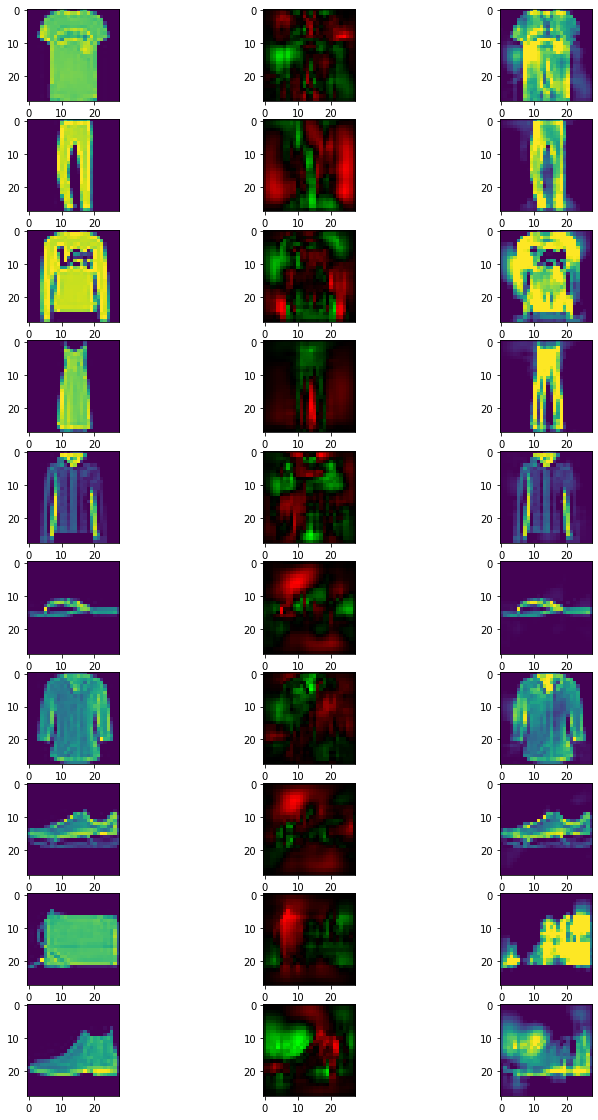

In [14]:
compute_and_display_gradient(vanilla_model, images, labels, targetted = [2,3,0,1,6,7,4,5,9,8])

### adversarial attacks

In [ ]:
import foolbox as fb

In [ ]:

hkr_fmodel = fb.TensorFlowModel(vanilla_model, bounds=(0., 1.), device="/GPU:0")

now we will attack the model to check if the certificates are respected. In this setup `L2CarliniWagnerAttack` is used but in practice as these kind of networks are gradient norm preserving, other attacks gives very similar results.

In [ ]:
attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=6, steps=8000)
imgs, advs, success = attack(hkr_fmodel, images, labels, epsilons=None)
dist_to_adv = np.sqrt(np.sum(np.square(images - advs), axis=(1,2,3)))
dist_to_adv

As we can see the certificate are respected.

In [ ]:
tf.assert_less(certificates, dist_to_adv)

Finally we can take a visual look at the obtained examples.
We first start with utility functions for display.

In [ ]:
class_mapping = {
  0: "T-shirt/top",
  1: "Trouser",
  2: "Pullover",
  3: "Dress",
  4: "Coat",
  5: "Sandal",
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle boot",
}

In [ ]:
def adversarial_viz(model, images, advs, class_mapping):
  """
  This functions shows for each sample: 
  - the original image
  - the adversarial image
  - the difference map
  - the certificate and the observed distance to adversarial 
  """
  scale = 1.5
  kwargs={}
  nb_imgs = images.shape[0]
  # compute certificates
  values, classes = tf.math.top_k(model(images), k=2)
  certificates = (values[:, 0] - values[:, 1]) / 2
  # compute difference distance to adversarial
  dist_to_adv = np.sqrt(np.sum(np.square(images - advs), axis=(1,2,3)))
  # find classes labels for imgs and advs
  orig_classes = [class_mapping[i] for i in tf.argmax(model(images), axis=-1).numpy()]
  advs_classes = [class_mapping[i] for i in tf.argmax(model(advs), axis=-1).numpy()]
  # compute differences maps
  if images.shape[-1] != 3:
    diff_pos = np.clip(advs - images, 0, 1.)
    diff_neg = np.clip(images - advs, 0, 1.)
    diff_map = np.concatenate([diff_neg, diff_pos, np.zeros_like(diff_neg)], axis=-1)
  else:
    diff_map = np.abs(advs - images)
  # expands image to be displayed
  if images.shape[-1] != 3:
    images = np.repeat(images, 3, -1)
  if advs.shape[-1] != 3:
    advs = np.repeat(advs, 3, -1)
  # create plot
  figsize = (3 * scale, nb_imgs * scale)
  fig, axes = plt.subplots(
    ncols=3,
    nrows=nb_imgs,
    figsize=figsize,
    squeeze=False,
    constrained_layout=True,
    **kwargs,
  )
  for i in range(nb_imgs):
    ax = axes[i][0]
    ax.set_title(orig_classes[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    ax.imshow(images[i])
    ax = axes[i][1]
    ax.set_title(advs_classes[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    ax.imshow(advs[i])
    ax = axes[i][2]
    ax.set_title(f"certif: {certificates[i]:.2f}, obs: {dist_to_adv[i]:.2f}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    ax.imshow(diff_map[i]/diff_map[i].max())

When looking at the adversarial examples we can see that the network has interresting properties:

#### predictability
by looking at the certificates, we can predict if the adversarial example will be close of not
#### disparity among classes
As we can see, the attacks are very efficent on similar classes (eg. T-shirt/top, and Shirt ). This denote that all classes are not made equal regarding robustness.
#### explainability
The network is more explainable: attacks can be used as counterfactuals.
We can tell that removing the inscription on a T-shirt turns it into a shirt makes sense. Non robust examples reveals that the network rely on textures rather on shapes to make it's decision.

In [ ]:
adversarial_viz(hkr_fmodel, images, advs, class_mapping)